In [ ]:
# !pip install tensorflow==2.15.0
# !pip install scikit-learn
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install matplotlib
# !pip install wordcloud
# !pip install nltk

  Using cached tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata (3.6 kB)
  Using cached tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata (5.1 kB)
  Using cached ml_dtypes-0.2.0-cp311-cp311-win_amd64.whl.metadata (20 kB)
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
  Using cached protobuf-4.25.5-cp310-abi3-win_amd64.whl.metadata (541 bytes)
  Using cached wrapt-1.14.1-cp311-cp311-win_amd64.whl.metadata (6.9 kB)
  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached google_auth-2.36.0-py2.py3-none-any.whl.metadata (4.7 kB)
  Using cached google_auth_oauthlib-1.2.1-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached cachetools-5.5.0-py3-none-any.whl.metadata (5.3 kB)
  Using cached pyasn1_modules-0.4.1-py3-none-any.whl.metadata (3.5 kB)
  Using cached rsa-4.9-py3-none-any.whl.

# Load Libraries

In [3]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import PorterStemmer
import re
import nltk
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.callbacks import EarlyStopping

# Your existing code
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')


# dl packages

# ml packages

# Load data

In [26]:
data = pd.read_csv('../Data/Twitter_Emotion_Dataset.csv')
# Jika file tidak memiliki header
df_kamus = pd.read_csv('../Data/kamus_singkatan.csv', delimiter=';')



In [27]:
print (df_kamus )

     singkatan kata_asli
0       aamiin     amin 
1         adek     adik 
2         adlh   adalah 
3          aer      air 
4      aiskrim  es krim 
...        ...       ...
1304       yoi       iya
1305       yup       ya 
1306      yups        ya
1307      yupz        ya
1308      ywdh  ya sudah

[1309 rows x 2 columns]


In [ ]:
# !pip uninstall kbbi
# !pip uninstall symspellpy

^C


In [51]:
from collections import Counter
import re

def tokens(text):
    return re.findall(r'\w+', text.lower())

# Pastikan file teks ada dan dapat dibaca
WORDS = Counter(tokens(open('./ind_mixed_2013_300K-sentences.txt').read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(tokens): 
    "The subset of `tokens` that are in the dictionary of WORDS."
    return set(w for w in tokens if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters = 'abcdefghijklmnopqrstuvwxyz'
    splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes = [L + R[1:] for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R) > 1]
    replaces = [L + c + R[1:] for L, R in splits if R for c in letters]
    inserts = [L + c + R for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def correct_typo(text):
    words = text.split()
    corrected_words = [correction(word) for word in words]  # Menggunakan fungsi correction
    return " ".join(corrected_words)


In [54]:
text = "makkan sampaee busukk"
corrected_text = correct_typo(text)
print(corrected_text)


makan sampai busuk


In [59]:
import pandas as pd
import re
from spellchecker import SpellChecker


kamus_singkatan = dict(zip(df_kamus['singkatan'], df_kamus['kata_asli']))

def clean_text(text):
    text = text.lower()  # Huruf kecil
    text = re.sub(r'http\S+', '', text)  # Hapus URL
    text = re.sub(r'@\w+', '', text)  # Hapus mention
    text = re.sub(r'#\w+', '', text)  # Hapus hashtag
    text = re.sub(r'\d+', '', text)  # Hapus angka
    text = re.sub(r'[^\w\s]', '', text)  # Hapus tanda baca
    text = text.strip()  # Hapus spasi berlebih
    return text

def expand_singkatan(text, kamus):
    words = text.split()
    expanded_words = [kamus[word] if word in kamus else word for word in words]
    return " ".join(expanded_words)


def preprocess_text(text, kamus):
    # Langkah 1: Bersihkan teks
    text = clean_text(text)
    
    # Langkah 2: Koreksi typo
    text = expand_singkatan(text, kamus)
    
    # Langkah 3: Perluas singkatan
    text = correct_typo(text)
    
    return text

data['processed_text'] = data['text'].apply(lambda x: preprocess_text(x, kamus_singkatan))

data[['text', 'processed_text']].head()


,text,processed_text
0,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",soal jalan jatibarupolisi tidak bisa gertak gu...
1,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",sesama cewek lho kayaknya harusnya bisa lebih ...
2,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,kepingin gudeg marek bu hj aman foto dari goog...
3,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",jalan jatibarubagian dari wilayah tn abangpeng...
4,"Sharing pengalaman aja, kemarin jam 18.00 bata...",sharing pengalaman saja kemarin jam batalion t...


In [60]:
data

,label,text,cleaned_text,expanded_text,processed_text
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",soal jln jatibarupolisi tdk bs gertak gubernur...,soal jalan jatibarupolisi tidak bisa gertak g...,soal jalan jatibarupolisi tidak bisa gertak gu...
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",sesama cewe lho kayaknya harusnya bisa lebih r...,sesama cewek lho kayaknya harusnya bisa lebih...,sesama cewek lho kayaknya harusnya bisa lebih ...
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,kepingin gudeg mbarek bu hj amad foto dari goo...,kepingin gudeg mbarek bu hj amad foto dari goo...,kepingin gudeg marek bu hj aman foto dari goog...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",jln jatibarubagian dari wilayah tn abangpengat...,jalan jatibarubagian dari wilayah tn abangpen...,jalan jatibarubagian dari wilayah tn abangpeng...
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata...",sharing pengalaman aja kemarin jam batalin ti...,sharing pengalaman saja kemarin jam batalin t...,sharing pengalaman saja kemarin jam batalion t...
...,...,...,...,...,...
4396,love,"Tahukah kamu, bahwa saat itu papa memejamkan m...",tahukah kamu bahwa saat itu papa memejamkan ma...,tahukah kamu bahwa saat itu papa memejamkan ma...,tahukah kamu bahwa saat itu papa memejamkan ma...
4397,fear,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,sulitnya menetapkan calon wapresnya jokowi di ...,sulitnya menetapkan calon wapresnya jokowi di ...,sulitnya menetapkan calon capresnya jokowi di ...
4398,anger,"5. masa depannya nggak jelas. lha iya, gimana ...",masa depannya nggak jelas lha iya gimana mau j...,masa depannya tidak jelas lha iya gimana mau j...,masa depannya tidak jelas lha iya gimana mau j...
4399,happy,[USERNAME] dulu beneran ada mahasiswa Teknik U...,username dulu beneran ada mahasiswa teknik ui ...,username dulu benar ada mahasiswa teknik ui n...,username dulu benar ada mahasiswa teknik ui ne...


In [ ]:
# # Save the cleaned data to a CSV file
# data.to_csv('cleaned_data.csv', index=False)

In [4]:
data = pd.read_csv('./corect_typo.csv')

In [5]:
unique_labels = data['label'].unique()
print(unique_labels)

['anger' 'happy' 'sadness' 'love' 'fear']


In [6]:
# Hapus baris dengan label 'cinta'
data = data[data['label'] != 'love']

# Verifikasi bahwa baris dengan label 'cinta' telah dihapus
print("Labels setelah penghapusan:", data['label'].unique())

Labels setelah penghapusan: ['anger' 'happy' 'sadness' 'fear']


In [7]:
# Hapus baris dengan label 'cinta'
data = data[data['label'] != 'fear']

# Verifikasi bahwa baris dengan label 'cinta' telah dihapus
print("Labels setelah penghapusan:", data['label'].unique())

Labels setelah penghapusan: ['anger' 'happy' 'sadness']


In [8]:
data.isnull().sum()

label             0
text              0
cleaned_text      0
expanded_text     0
processed_text    0
dtype: int64

In [9]:
data.duplicated().sum()

7

In [10]:
data = data.drop_duplicates()

In [11]:
data.shape

(3108, 5)

# EDA

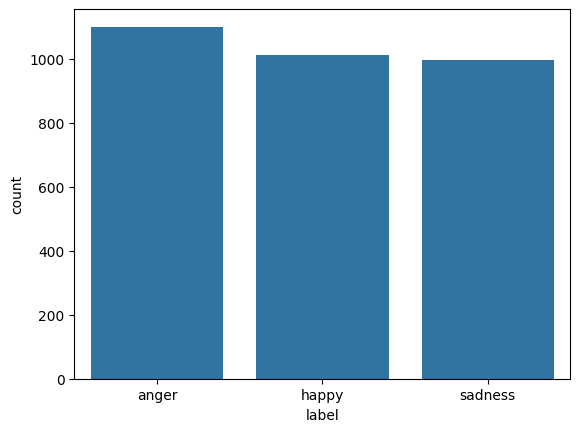

In [ ]:
sns.countplot(x=data['label'])
plt.show()

# Data Preprocessing
# Encode emotions

In [13]:
lb = LabelEncoder()
data['label'] = lb.fit_transform(data['label'])

In [14]:
data

,label,text,cleaned_text,expanded_text,processed_text
0,0,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",soal jln jatibarupolisi tdk bs gertak gubernur...,soal jalan jatibarupolisi tidak bisa gertak g...,soal jalan jatibarupolisi tidak bisa gertak gu...
1,0,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",sesama cewe lho kayaknya harusnya bisa lebih r...,sesama cewek lho kayaknya harusnya bisa lebih...,sesama cewek lho kayaknya harusnya bisa lebih ...
2,1,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,kepingin gudeg mbarek bu hj amad foto dari goo...,kepingin gudeg mbarek bu hj amad foto dari goo...,kepingin gudeg marek bu hj aman foto dari goog...
3,0,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",jln jatibarubagian dari wilayah tn abangpengat...,jalan jatibarubagian dari wilayah tn abangpen...,jalan jatibarubagian dari wilayah tn abangpeng...
4,1,"Sharing pengalaman aja, kemarin jam 18.00 bata...",sharing pengalaman aja kemarin jam batalin ti...,sharing pengalaman saja kemarin jam batalin t...,sharing pengalaman saja kemarin jam batalion t...
...,...,...,...,...,...
4394,2,Mengubah kebiasaan seseorang yg kurang baik it...,mengubah kebiasaan seseorang yg kurang baik it...,mengubah kebiasaan seseorang yang kurang baik...,mengubah kebiasaan seseorang yang kurang baik ...
4395,2,nah diam lebih bagus yaudah saya diam saja deh...,nah diam lebih bagus yaudah saya diam saja deh...,nah diam lebih bagus yaudah saya diam saja deh...,nah diam lebih bagus yaudah saya diam saja deh...
4398,0,"5. masa depannya nggak jelas. lha iya, gimana ...",masa depannya nggak jelas lha iya gimana mau j...,masa depannya tidak jelas lha iya gimana mau j...,masa depannya tidak jelas lha iya gimana mau j...
4399,1,[USERNAME] dulu beneran ada mahasiswa Teknik U...,username dulu beneran ada mahasiswa teknik ui ...,username dulu benar ada mahasiswa teknik ui n...,username dulu benar ada mahasiswa teknik ui ne...


# Applying Deep learning Using LSTM

# Text Cleaning, Encoding, and Padding

In [15]:
import concurrent.futures
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Download stopwords jika belum ada
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('indonesian'))

# # Menambahkan stopwords khusus yang relevan
# additional_stopwords = {'orang', 'rasa', 'asa', 'pikir', 'buat', 'hidup', 'suka'}
# stopwords.update(additional_stopwords)

# Inisialisasi stemmer dari Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

negasi_words = ['tidak', 'gak', 'bukan', 'jangan']
intensifikasi_words = ['sangat', 'terlalu', 'amat', 'banget']

# Fungsi untuk menangani negasi dan intensifikasi
def handle_negasi_and_intensifikasi(text):
    words = text.split()
    modified_words = []
    negate_next = False  # Menandai apakah kata berikutnya harus dimodifikasi

    for i, word in enumerate(words):
        # Jika kata negasi ditemukan
        if word in negasi_words:
            negate_next = True
            modified_words.append('_NEG_')
        elif word in intensifikasi_words:
            # Jika kata intensifikasi ditemukan, tambahkan tag intensifikasi
            modified_words.append('_INTENS_')
        else:
            if negate_next:
                # Jika negasi sebelumnya ditemukan, ubah makna kata
                word = 'tidak_' + word
                negate_next = False
            modified_words.append(word)
    
    return " ".join(modified_words)


# Fungsi untuk membersihkan teks
def clean_text(text):
    # Menghapus karakter non-alfabet (kecuali tanda baca tertentu)
    text = re.sub("[^a-zA-Z!?]", " ", text)
    
    # Mengubah teks menjadi huruf kecil
    text = text.lower()
    
    text = handle_negasi_and_intensifikasi(text)
    
    # Tokenisasi kata
    words = text.split()
    
    # Menghapus stopwords
    words = [word for word in words if word not in stopwords]
    
    # Lakukan stemming
    words = [stemmer.stem(word) for word in words]
    
    # Gabungkan kata-kata yang sudah diproses menjadi satu string
    return " ".join(words)

# Parallel processing dengan concurrent.futures

def process_batch(batch):
    return [clean_text(text) for text in batch]

# Menyusun data dalam batch
batch_size = 500  # Tentukan ukuran batch
batches = [data['processed_text'].iloc[i:i + batch_size] for i in range(0, len(data), batch_size)]

# Parallel processing menggunakan ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(process_batch, batches))

# Gabungkan hasilnya menjadi satu dataframe
processed_data = [item for sublist in results for item in sublist]
data['teks_clean'] = processed_data

# Tokenization
tokenizer = Tokenizer(num_words=11000, oov_token="<OOV>")
tokenizer.fit_on_texts(data['teks_clean'])
sequences = tokenizer.texts_to_sequences(data['teks_clean'])

# Padding sequences untuk panjang input yang konsisten
x = pad_sequences(sequences, maxlen=500, padding='post')

# Label encoding (one-hot encoding)
y = to_categorical(data["label"])

# Cek hasil
print(data['teks_clean'].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\haldies\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    jalan jatibarupolisi neg tidak bisa gertak gub...
1    cewek lho kayak rasain sibuk jaga rasain sakit...
2    kepingin gudeg marek bu hj aman foto google se...
3    jalan jatibarubagian wilayah tn abangpengatura...
4    sharing alam kemarin jam batalion tiket stasiu...
Name: teks_clean, dtype: object


In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Output shapes
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")

x_train shape: (2486, 500), x_test shape: (622, 500)


In [19]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# Fungsi untuk menghitung kata per label
def word_count_per_label(data, label_column, text_column):
    label_word_counts = {}

    # Loop untuk setiap label dalam kolom 'emosi_label'
    for label in data[label_column].unique():
        # Ambil teks yang sesuai dengan label
        label_texts = data[data[label_column] == label][text_column]
        
        # Gabungkan seluruh teks untuk label tersebut menjadi satu string
        all_cleaned_text = " ".join(label_texts)
        
        # Pisahkan string menjadi kata-kata
        words = all_cleaned_text.split()
        
        # Hitung frekuensi kata untuk label tersebut
        word_counts = Counter(words)
        
        # Simpan hasil frekuensi kata per label
        label_word_counts[label] = word_counts

    return label_word_counts

# Mapping label numerik ke emosi
label_mapping = {0: 'marah', 1: 'senang', 2: 'sedih', 3: 'netral'}

# Ganti label numerik dengan label emosi yang lebih mudah dibaca
data['emosi_label'] = data['label'].map(label_mapping)

Top 10 Kata untuk Label 'marah':
neg: 1007
tidak: 999
username: 838
orang: 264
ya: 225
url: 167
pakai: 106
sih: 104
intens: 88
salah: 86

----------------------------------------


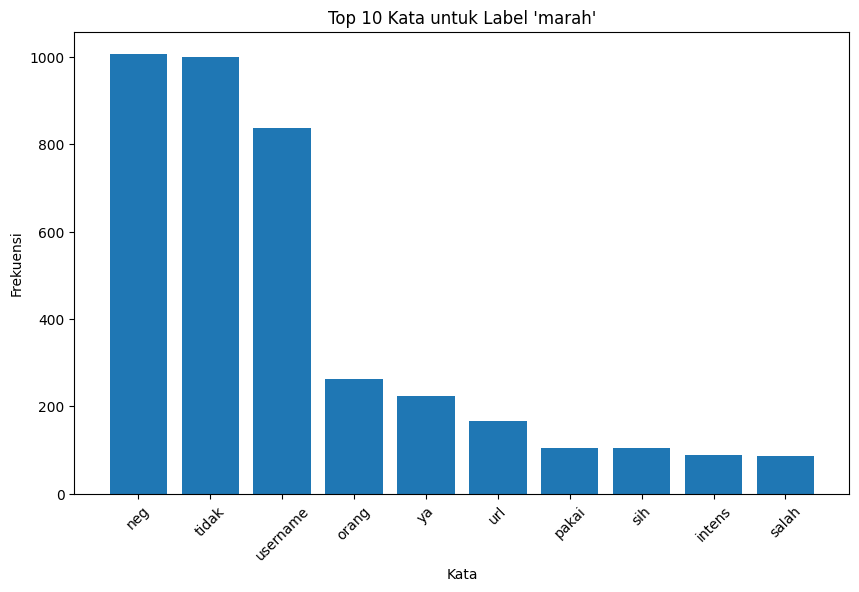

Top 10 Kata untuk Label 'senang':
username: 446
tidak: 399
neg: 398
url: 217
ya: 145
orang: 139
moga: 97
kasih: 96
intens: 77
nya: 76

----------------------------------------


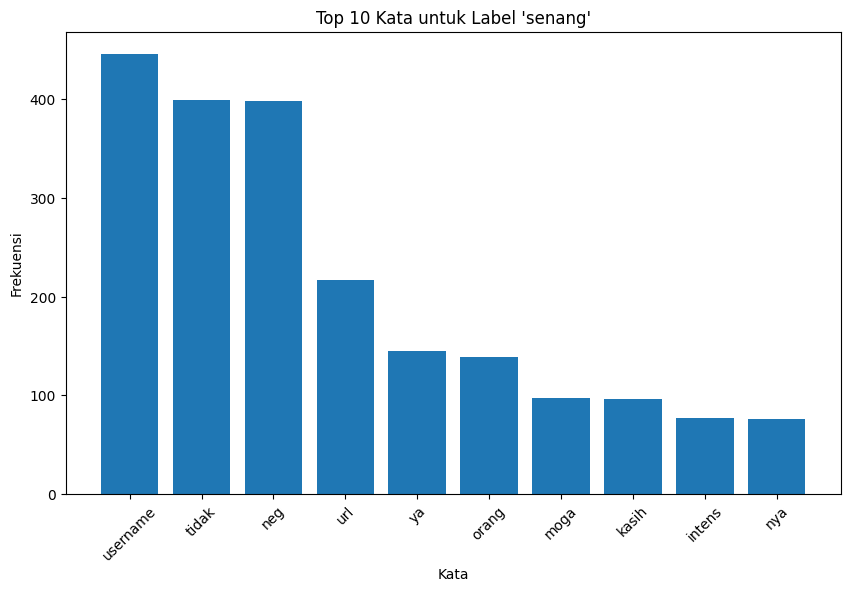

Top 10 Kata untuk Label 'sedih':
neg: 657
tidak: 649
username: 223
ya: 173
orang: 171
intens: 112
url: 102
hati: 78
ku: 78
sakit: 77

----------------------------------------


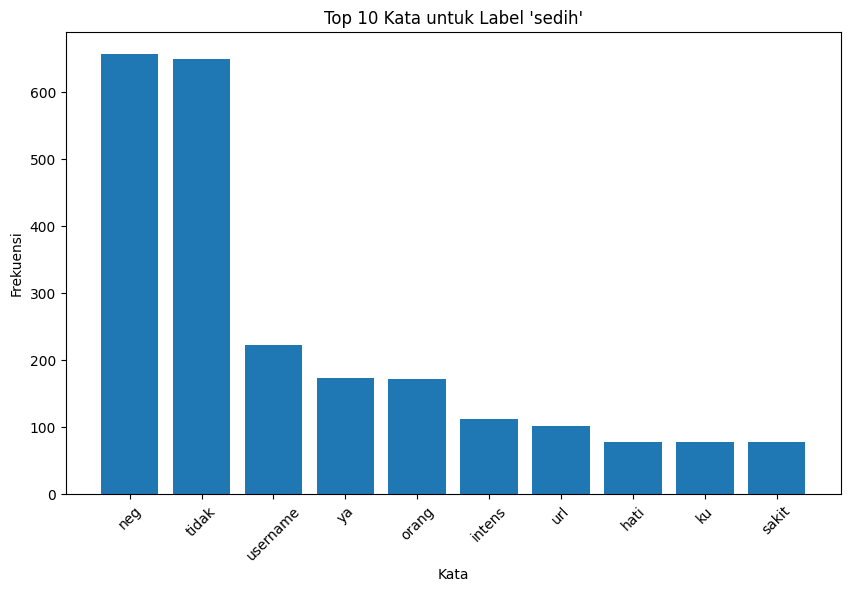

In [20]:
label_word_counts = word_count_per_label(data, label_column='emosi_label', text_column='teks_clean')

def plot_word_counts(label_word_counts):
    for label, word_counts in label_word_counts.items():
      
        most_common_words = word_counts.most_common(10)
        
        words, counts = zip(*most_common_words)
        
        print(f"Top 10 Kata untuk Label '{label}':")
        for word, count in zip(words, counts):
            print(f"{word}: {count}")
        print("\n" + "-"*40)
        
        plt.figure(figsize=(10, 6))
        plt.bar(words, counts)
        plt.title(f"Top 10 Kata untuk Label '{label}'")
        plt.xlabel("Kata")
        plt.ylabel("Frekuensi")
        plt.xticks(rotation=45)
        plt.show()

plot_word_counts(label_word_counts)

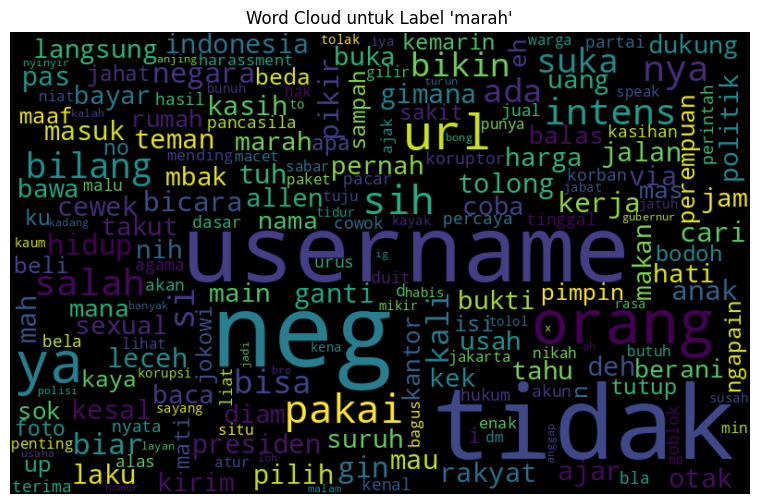

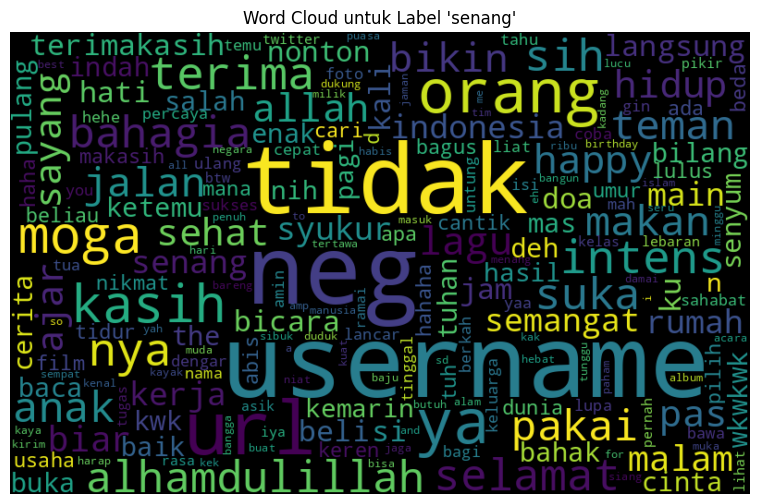

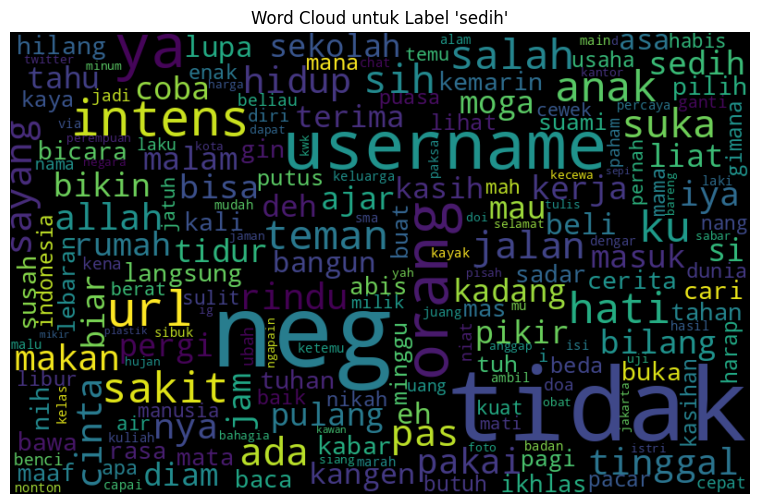

In [21]:
def plot_wordcloud(label_word_counts):
    for label, word_counts in label_word_counts.items():
        wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate_from_frequencies(word_counts)
        
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud untuk Label '{label}'")
        plt.show()

plot_wordcloud(label_word_counts)

# Model Building and Training

In [29]:
from tensorflow.keras.layers import Bidirectional, LSTM, Embedding, Dropout, Dense
from keras.models import Sequential

def create_model(lstm_units=128, dropout_rate=0.2):
    model = Sequential()
    model.add(Embedding(input_dim=11000, output_dim=150, input_length=500))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(lstm_units)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model


In [30]:
model = create_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 150)          1650000   
                                                                 
 dropout_5 (Dropout)         (None, 500, 150)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              285696    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                      

In [31]:
history = model.fit(x_train, y_train, 
                    epochs=10, 
                    validation_data=(x_test, y_test), 
                    batch_size=64, verbose=1)



Epoch 1/10
39/39 [==============================] - 29s 335ms/step - loss: 1.1816 - accuracy: 0.3367 - val_loss: 1.0852 - val_accuracy: 0.4196
Epoch 2/10
39/39 [==============================] - 11s 279ms/step - loss: 0.9612 - accuracy: 0.5257 - val_loss: 0.8666 - val_accuracy: 0.6125
Epoch 3/10
39/39 [==============================] - 11s 279ms/step - loss: 0.4643 - accuracy: 0.8355 - val_loss: 0.9005 - val_accuracy: 0.6302
Epoch 4/10
39/39 [==============================] - 11s 284ms/step - loss: 0.1925 - accuracy: 0.9469 - val_loss: 1.0735 - val_accuracy: 0.6206
Epoch 5/10
39/39 [==============================] - 11s 273ms/step - loss: 0.0963 - accuracy: 0.9783 - val_loss: 1.1114 - val_accuracy: 0.6350
Epoch 6/10
39/39 [==============================] - 11s 281ms/step - loss: 0.0564 - accuracy: 0.9879 - val_loss: 1.4293 - val_accuracy: 0.6077
Epoch 7/10
39/39 [==============================] - 11s 275ms/step - loss: 0.0378 - accuracy: 0.9928 - val_loss: 1.4496 - val_accuracy: 0.6238

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

def train_model(model, x_train, y_train):
    model.fit(x_train, y_train)
    return model

def get_F1(model, x_test, y_test):
    y_pred = model.predict(x_test)
    return f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average=None)

# Assuming x_train, y_train, x_test, y_test, and df_train are already defined
RF = train_model(RandomForestClassifier(random_state=0), x_train, y_train)

# Optionally, you can evaluate the model
y_pred = RF.predict(x_test)
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(f"Accuracy: {accuracy}")

# Calculate the F1 score
f1_Score = get_F1(RF, x_test, y_test)
pd.DataFrame(f1_Score, index=data['label'].unique(), columns=['F1 score'])

Accuracy: 0.35852090032154343


,F1 score
0,0.521303
1,0.108108
2,0.026786


In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.19      0.28       213
           1       0.52      0.06      0.11       199
           2       0.21      0.01      0.03       210

   micro avg       0.50      0.09      0.15       622
   macro avg       0.43      0.09      0.14       622
weighted avg       0.42      0.09      0.14       622
 samples avg       0.09      0.09      0.09       622



# Predictive System

In [48]:
import numpy as np
import re
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Pastikan stopwords tersedia
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('indonesian'))

# Tambahkan stopwords khusus
additional_stopwords = {'orang', 'rasa', 'asa', 'pikir', 'buat', 'hidup', 'suka'}
stopwords.update(additional_stopwords)

# Inisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Fungsi preprocessing kalimat
def sentence_cleaning(sentence, tokenizer, max_length=500):
    text = re.sub("[^a-zA-Z]", " ", sentence)  # Hanya huruf
    text = text.lower()  # Konversi ke huruf kecil
    text = text.split()  # Tokenisasi
    text = [stemmer.stem(word) for word in text if word not in stopwords]  # Stemming dan hapus stopwords
    text = " ".join(text)  # Gabungkan kembali
    sequences = tokenizer.texts_to_sequences([text])  # Konversi teks ke sequences
    pad = pad_sequences(sequences, maxlen=max_length, padding='post')  # Padding sequences
    return pad

# Muat tokenizer (harus sama seperti saat training)
tokenizer = Tokenizer(num_words=11000, oov_token="<OOV>")
tokenizer.fit_on_texts(["dummy"])  # Ini placeholder jika tokenizer belum tersedia

# Muat model
model = load_model('best_model.h5')

# Prediksi
sentences = [
    "asa rasa",
]
label_mapping = {0: 'marah', 1: 'senang', 2: 'sedih', 3: 'netral'}
for sentence in sentences:
    print("Kalimat:", sentence)
    processed_sentence = sentence_cleaning(sentence, tokenizer)
    proba = model.predict(processed_sentence)
    result = np.argmax(proba, axis=-1)[0]  
    print(f"Label Prediksi: {label_mapping[result]} | Probabilitas: {proba[0]}\n")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\haldies\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


OSError: No file or directory found at best_model.h5

# Save the model and files